In [70]:
import os
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from dataset_utils import ConstructDataset
%matplotlib inline

In [2]:
def load_cifar10(num_training=49000, num_validation=1000, num_test=10000):
    """
    Fetch the CIFAR-10 dataset from the web and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 dataset and use appropriate data types and shapes
    cifar10 = tf.keras.datasets.cifar10.load_data()
    (X_train, y_train), (X_test, y_test) = cifar10
    X_train = np.asarray(X_train, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.int32).flatten()
    X_test = np.asarray(X_test, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.int32).flatten()

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean pixel and divide by std
    mean_pixel = X_train.mean(axis=(0, 1, 2), keepdims=True)
    std_pixel = X_train.std(axis=(0, 1, 2), keepdims=True)
    X_train = (X_train - mean_pixel) / std_pixel
    X_val = (X_val - mean_pixel) / std_pixel
    X_test = (X_test - mean_pixel) / std_pixel

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
NHW = (0, 1, 2)
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int32
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Preparation: Dataset object

For our own convenience we'll define a lightweight `Dataset` class which lets us iterate over data and labels. This is not the most flexible or most efficient way to iterate through data, but it will serve our purposes.

In [2]:
train_dset = ConstructDataset()
# train_dset = Dataset(X_train, y_train, batch_size=64, shuffle=True)
# val_dset = Dataset(X_val, y_val, batch_size=64, shuffle=False)
# test_dset = Dataset(X_test, y_test, batch_size=64)

(2, 240, 320, 3) (2, 240, 320)


In [4]:
# We can iterate through a dataset like this:
for t, (x, y) in enumerate(train_dset):
    print(t, x.shape, y.shape)
    if t > 5: break

0 (64, 32, 32, 3) (64,)
1 (64, 32, 32, 3) (64,)
2 (64, 32, 32, 3) (64,)
3 (64, 32, 32, 3) (64,)
4 (64, 32, 32, 3) (64,)
5 (64, 32, 32, 3) (64,)
6 (64, 32, 32, 3) (64,)


You can optionally **use GPU by setting the flag to True below**. It's not neccessary to use a GPU for this assignment; if you are working on Google Cloud then we recommend that you do not use a GPU, as it will be significantly more expensive.

In [5]:
# Set up some global variables
USE_GPU = True

if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'

# Constant to control how often we print when training models
print_every = 100

print('Using device: ', device)

Using device:  /device:GPU:0


# Part III: Keras Model API
Implementing a neural network using the low-level TensorFlow API is a good way to understand how TensorFlow works, but it's a little inconvenient - we had to manually keep track of all Tensors holding learnable parameters, and we had to use a control dependency to implement the gradient descent update step. This was fine for a small network, but could quickly become unweildy for a large complex model.

Fortunately TensorFlow provides higher-level packages such as `tf.keras` and `tf.layers` which make it easy to build models out of modular, object-oriented layers; `tf.train` allows you to easily train these models using a variety of different optimization algorithms.

In this part of the notebook we will define neural network models using the `tf.keras.Model` API. To implement your own model, you need to do the following:

1. Define a new class which subclasses `tf.keras.model`. Give your class an intuitive name that describes it, like `TwoLayerFC` or `ThreeLayerConvNet`.
2. In the initializer `__init__()` for your new class, define all the layers you need as class attributes. The `tf.layers` package provides many common neural-network layers, like `tf.layers.Dense` for fully-connected layers and `tf.layers.Conv2D` for convolutional layers. Under the hood, these layers will construct `Variable` Tensors for any learnable parameters. **Warning**: Don't forget to call `super().__init__()` as the first line in your initializer!
3. Implement the `call()` method for your class; this implements the forward pass of your model, and defines the *connectivity* of your network. Layers defined in `__init__()` implement `__call__()` so they can be used as function objects that transform input Tensors into output Tensors. Don't define any new layers in `call()`; any layers you want to use in the forward pass should be defined in `__init__()`.

After you define your `tf.keras.Model` subclass, you can instantiate it and use it like the model functions from Part II.

### Module API: Two-Layer Network

Here is a concrete example of using the `tf.keras.Model` API to define a two-layer network. There are a few new bits of API to be aware of here:

We use an `Initializer` object to set up the initial values of the learnable parameters of the layers; in particular `tf.variance_scaling_initializer` gives behavior similar to the Kaiming initialization method we used in Part II. You can read more about it here: https://www.tensorflow.org/api_docs/python/tf/variance_scaling_initializer

We construct `tf.layers.Dense` objects to represent the two fully-connected layers of the model. In addition to multiplying their input by a weight matrix and adding a bias vector, these layer can also apply a nonlinearity for you. For the first layer we specify a ReLU activation function by passing `activation=tf.nn.relu` to the constructor; the second layer does not apply any activation function.

Unfortunately the `flatten` function we defined in Part II is not compatible with the `tf.keras.Model` API; fortunately we can use `tf.layers.flatten` to perform the same operation. The issue with our `flatten` function from Part II has to do with static vs dynamic shapes for Tensors, which is beyond the scope of this notebook; you can read more about the distinction [in the documentation](https://www.tensorflow.org/programmers_guide/faq#tensor_shapes).

In [6]:
class TwoLayerFC(tf.keras.Model):
    def __init__(self, hidden_size, num_classes):
        super().__init__()        
        initializer = tf.variance_scaling_initializer(scale=2.0)
        self.fc1 = tf.layers.Dense(hidden_size, activation=tf.nn.relu,
                                   kernel_initializer=initializer)
        self.fc2 = tf.layers.Dense(num_classes,
                                   kernel_initializer=initializer)
    def call(self, x, training=None):
        x = tf.layers.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


def test_TwoLayerFC():
    """ A small unit test to exercise the TwoLayerFC model above. """
    tf.reset_default_graph()
    input_size, hidden_size, num_classes = 50, 42, 10

    # As usual in TensorFlow, we first need to define our computational graph.
    # To this end we first construct a TwoLayerFC object, then use it to construct
    # the scores Tensor.
    model = TwoLayerFC(hidden_size, num_classes)
    with tf.device(device):
        x = tf.zeros((64, input_size))
        scores = model(x)

    # Now that our computational graph has been defined we can run the graph
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        scores_np = sess.run(scores)
        print(scores_np.shape)
        
test_TwoLayerFC()

(64, 10)


### Keras Model API: Three-Layer ConvNet
Now it's your turn to implement a three-layer ConvNet using the `tf.keras.Model` API. Your model should have the same architecture used in Part II:

1. Convolutional layer with 5 x 5 kernels, with zero-padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 3 x 3 kernels, with zero-padding of 1
4. ReLU nonlinearity
5. Fully-connected layer to give class scores

You should initialize the weights of your network using the same initialization method as was used in the two-layer network above.

**Hint**: Refer to the documentation for `tf.layers.Conv2D` and `tf.layers.Dense`:

https://www.tensorflow.org/api_docs/python/tf/layers/Conv2D

https://www.tensorflow.org/api_docs/python/tf/layers/Dense

In [7]:
class ThreeLayerConvNet(tf.keras.Model):
    def __init__(self, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Implement the __init__ method for a three-layer ConvNet. You   #
        # should instantiate layer objects to be used in the forward pass.     #
        ########################################################################
        initializer = tf.variance_scaling_initializer(scale=2.0)
        self.conv1 = tf.layers.Conv2D(channel_1, [5,5], 1, "SAME", activation=tf.nn.relu, 
                                     kernel_initializer=initializer, use_bias=True)
        self.conv2 = tf.layers.Conv2D(channel_2, [3,3], 1, "SAME", activation=tf.nn.relu, 
                                     kernel_initializer=initializer, use_bias=True)
        self.fc2 = tf.layers.Dense(num_classes,
                                   kernel_initializer=initializer, use_bias=True)
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################
        
    def call(self, x, training=None):
        scores = None
        ########################################################################
        # TODO: Implement the forward pass for a three-layer ConvNet. You      #
        # should use the layer objects defined in the __init__ method.         #
        ########################################################################
        x = self.conv1(x)
        x = self.conv2(x)
        x = tf.layers.flatten(x)
        scores = self.fc2(x)
        ########################################################################
        #                           END OF YOUR CODE                           #
        ########################################################################        
        return scores

Once you complete the implementation of the `ThreeLayerConvNet` above you can run the following to ensure that your implementation does not crash and produces outputs of the expected shape.

In [8]:
def test_ThreeLayerConvNet():
    tf.reset_default_graph()
    
    channel_1, channel_2, num_classes = 12, 8, 10
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    with tf.device(device):
        x = tf.zeros((64, 3, 32, 32))
        scores = model(x)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        scores_np = sess.run(scores)
        print(scores_np.shape)

test_ThreeLayerConvNet()

(64, 10)


### Keras Model API: Training Loop
We need to implement a slightly different training loop when using the `tf.keras.Model` API. Instead of computing gradients and updating the weights of the model manually, we use an `Optimizer` object from the `tf.train` package which takes care of these details for us. You can read more about `Optimizer`s here: https://www.tensorflow.org/api_docs/python/tf/train/Optimizer

In [11]:
def train_part34(model_init_fn, optimizer_init_fn, num_epochs=1):
    """
    Simple training loop for use with models defined using tf.keras. It trains
    a model for one epoch on the CIFAR-10 training set and periodically checks
    accuracy on the CIFAR-10 validation set.
    
    Inputs:
    - model_init_fn: A function that takes no parameters; when called it
      constructs the model we want to train: model = model_init_fn()
    - optimizer_init_fn: A function which takes no parameters; when called it
      constructs the Optimizer object we will use to optimize the model:
      optimizer = optimizer_init_fn()
    - num_epochs: The number of epochs to train for
    
    Returns: Nothing, but prints progress during trainingn
    """
    tf.reset_default_graph()    
    with tf.device(device):
        # Construct the computational graph we will use to train the model. We
        # use the model_init_fn to construct the model, declare placeholders for
        # the data and labels
        x = tf.placeholder(tf.float32, [None, 32, 32, 3])
        y = tf.placeholder(tf.int32, [None])
        
        # We need a place holder to explicitly specify if the model is in the training
        # phase or not. This is because a number of layers behaves differently in
        # training and in testing, e.g., dropout and batch normalization.
        # We pass this variable to the computation graph through feed_dict as shown below.
        is_training = tf.placeholder(tf.bool, name='is_training')
        
        # Use the model function to build the forward pass.
        scores = model_init_fn(x, is_training)

        # Compute the loss like we did in Part II
        loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(loss)

        # Use the optimizer_fn to construct an Optimizer, then use the optimizer
        # to set up the training step. Asking TensorFlow to evaluate the
        # train_op returned by optimizer.minimize(loss) will cause us to make a
        # single update step using the current minibatch of data.
        
        # Note that we use tf.control_dependencies to force the model to run
        # the tf.GraphKeys.UPDATE_OPS at each training step. tf.GraphKeys.UPDATE_OPS
        # holds the operators that update the states of the network.
        # For example, the tf.layers.batch_normalization function adds the running mean
        # and variance update operators to tf.GraphKeys.UPDATE_OPS.
        optimizer = optimizer_init_fn()
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            train_op = optimizer.minimize(loss)

    # Now we can run the computational graph many times to train the model.
    # When we call sess.run we ask it to evaluate train_op, which causes the
    # model to update.
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        t = 0
        for epoch in range(num_epochs):
            print('Starting epoch %d' % epoch)
            for x_np, y_np in train_dset:
                feed_dict = {x: x_np, y: y_np, is_training:1}
                loss_np, _ = sess.run([loss, train_op], feed_dict=feed_dict)
                if t % print_every == 0:
                    print('Iteration %d, loss = %.4f' % (t, loss_np))
#                     check_accuracy(sess, val_dset, x, scores, is_training=is_training)
                    print()
                t += 1

### Keras Model API: Train a Two-Layer Network
We can now use the tools defined above to train a two-layer network on CIFAR-10. We define the `model_init_fn` and `optimizer_init_fn` that construct the model and optimizer respectively when called. Here we want to train the model using stochastic gradient descent with no momentum, so we construct a `tf.train.GradientDescentOptimizer` function; you can [read about it here](https://www.tensorflow.org/api_docs/python/tf/train/GradientDescentOptimizer).

You don't need to tune any hyperparameters here, but you should achieve accuracies above 40% after one epoch of training.

In [12]:
hidden_size, num_classes = 4000, 10
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    return TwoLayerFC(hidden_size, num_classes)(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.8514

Iteration 100, loss = 1.8389

Iteration 200, loss = 1.3685

Iteration 300, loss = 1.7910

Iteration 400, loss = 1.7299

Iteration 500, loss = 1.7253

Iteration 600, loss = 1.8212

Iteration 700, loss = 1.7311



### Keras Model API: Train a Three-Layer ConvNet
Here you should use the tools we've defined above to train a three-layer ConvNet on CIFAR-10. Your ConvNet should use 32 filters in the first convolutional layer and 16 filters in the second layer.

To train the model you should use gradient descent with Nesterov momentum 0.9. 

**HINT**: https://www.tensorflow.org/api_docs/python/tf/train/MomentumOptimizer

You don't need to perform any hyperparameter tuning, but you should achieve accuracies above 45% after training for one epoch.

In [13]:
learning_rate = 3e-3
channel_1, channel_2, num_classes = 32, 16, 10

def model_init_fn(inputs, is_training):
    model = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    model = ThreeLayerConvNet(channel_1, channel_2, num_classes)
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return model(inputs)

def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True)
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 2.5225

Iteration 100, loss = 1.7209

Iteration 200, loss = 1.3316

Iteration 300, loss = 1.4147

Iteration 400, loss = 1.1858

Iteration 500, loss = 1.4059

Iteration 600, loss = 1.4851

Iteration 700, loss = 1.2732



# Part IV: Keras Sequential API
In Part III we introduced the `tf.keras.Model` API, which allows you to define models with any number of learnable layers and with arbitrary connectivity between layers.

However for many models you don't need such flexibility - a lot of models can be expressed as a sequential stack of layers, with the output of each layer fed to the next layer as input. If your model fits this pattern, then there is an even easier way to define your model: using `tf.keras.Sequential`. You don't need to write any custom classes; you simply call the `tf.keras.Sequential` constructor with a list containing a sequence of layer objects.

One complication with `tf.keras.Sequential` is that you must define the shape of the input to the model by passing a value to the `input_shape` of the first layer in your model.

### Keras Sequential API: Two-Layer Network
Here we rewrite the two-layer fully-connected network using `tf.keras.Sequential`, and train it using the training loop defined above.

You don't need to perform any hyperparameter tuning here, but you should see accuracies above 40% after training for one epoch.

In [28]:
learning_rate = 1e-2

def model_init_fn(inputs, is_training):
    input_shape = (32, 32, 3)
    hidden_layer_size, num_classes = 4000, 10
    initializer = tf.variance_scaling_initializer(scale=2.0)
    layers = [
        tf.layers.Flatten(input_shape=input_shape),
        tf.layers.Dense(hidden_layer_size, activation=tf.nn.relu,
                        kernel_initializer=initializer),
        tf.layers.Dense(num_classes, kernel_initializer=initializer),
    ]
    model = tf.keras.Sequential(layers)
    return model(inputs)

def optimizer_init_fn():
    return tf.train.GradientDescentOptimizer(learning_rate)

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 3.0356
Got 131 / 1000 correct (13.10%)

Iteration 100, loss = 1.8742
Got 385 / 1000 correct (38.50%)

Iteration 200, loss = 1.4500
Got 412 / 1000 correct (41.20%)

Iteration 300, loss = 1.7041
Got 404 / 1000 correct (40.40%)

Iteration 400, loss = 1.7376
Got 431 / 1000 correct (43.10%)

Iteration 500, loss = 1.7235
Got 445 / 1000 correct (44.50%)

Iteration 600, loss = 1.7746
Got 440 / 1000 correct (44.00%)

Iteration 700, loss = 1.7713
Got 442 / 1000 correct (44.20%)



### Keras Sequential API: Three-Layer ConvNet
Here you should use `tf.keras.Sequential` to reimplement the same three-layer ConvNet architecture used in Part II and Part III. As a reminder, your model should have the following architecture:

1. Convolutional layer with 16 5x5 kernels, using zero padding of 2
2. ReLU nonlinearity
3. Convolutional layer with 32 3x3 kernels, using zero padding of 1
4. ReLU nonlinearity
5. Fully-connected layer giving class scores

You should initialize the weights of the model using a `tf.variance_scaling_initializer` as above.

You should train the model using Nesterov momentum 0.9.

You don't need to perform any hyperparameter search, but you should achieve accuracy above 45% after training for one epoch.

In [29]:
def model_init_fn(inputs, is_training):
    model = None
    ############################################################################
    # TODO: Construct a three-layer ConvNet using tf.keras.Sequential.         #
    ############################################################################
    initializer = tf.variance_scaling_initializer(scale=2.0)
    input_shape = (32, 32, 3)
    layers = [
        tf.layers.Conv2D(channel_1, [5,5], 1, "SAME", activation=tf.nn.relu,
                         kernel_initializer=initializer, use_bias=True,
                         input_shape=input_shape),
        tf.layers.Conv2D(channel_2, [3,3], 1, "SAME", activation=tf.nn.relu, 
                                     kernel_initializer=initializer, use_bias=True),
        tf.layers.Flatten(),
        tf.layers.Dense(num_classes, kernel_initializer=initializer, use_bias=True)
    ]
    model = tf.keras.Sequential(layers)
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return model(inputs)

learning_rate = 5e-4
def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True)
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

train_part34(model_init_fn, optimizer_init_fn)

Starting epoch 0
Iteration 0, loss = 3.2144
Got 82 / 1000 correct (8.20%)

Iteration 100, loss = 1.8631
Got 384 / 1000 correct (38.40%)

Iteration 200, loss = 1.4894
Got 406 / 1000 correct (40.60%)

Iteration 300, loss = 1.6356
Got 440 / 1000 correct (44.00%)

Iteration 400, loss = 1.5258
Got 476 / 1000 correct (47.60%)

Iteration 500, loss = 1.6699
Got 487 / 1000 correct (48.70%)

Iteration 600, loss = 1.6472
Got 487 / 1000 correct (48.70%)

Iteration 700, loss = 1.5363
Got 510 / 1000 correct (51.00%)



# Part V: CIFAR-10 open-ended challenge

In this section you can experiment with whatever ConvNet architecture you'd like on CIFAR-10.

You should experiment with architectures, hyperparameters, loss functions, regularization, or anything else you can think of to train a model that achieves **at least 70%** accuracy on the **validation** set within 10 epochs. You can use the `check_accuracy` and `train` functions from above, or you can implement your own training loop.

Describe what you did at the end of the notebook.

### Some things you can try:
- **Filter size**: Above we used 5x5 and 3x3; is this optimal?
- **Number of filters**: Above we used 16 and 32 filters. Would more or fewer do better?
- **Pooling**: We didn't use any pooling above. Would this improve the model?
- **Normalization**: Would your model be improved with batch normalization, layer normalization, group normalization, or some other normalization strategy?
- **Network architecture**: The ConvNet above has only three layers of trainable parameters. Would a deeper model do better?
- **Global average pooling**: Instead of flattening after the final convolutional layer, would global average pooling do better? This strategy is used for example in Google's Inception network and in Residual Networks.
- **Regularization**: Would some kind of regularization improve performance? Maybe weight decay or dropout?

### WARNING: Batch Normalization / Dropout
Batch Normalization and Dropout **WILL NOT WORK CORRECTLY** if you use the `train_part34()` function with the object-oriented `tf.keras.Model` or `tf.keras.Sequential` APIs; if you want to use these layers with this training loop then you **must use the tf.layers functional API**.

We wrote `train_part34()` to explicitly demonstrate how TensorFlow works; however there are some subtleties that make it tough to handle the object-oriented batch normalization layer in a simple training loop. In practice both `tf.keras` and `tf` provide higher-level APIs which handle the training loop for you, such as [keras.fit](https://keras.io/models/sequential/) and [tf.Estimator](https://www.tensorflow.org/programmers_guide/estimators), both of which will properly handle batch normalization when using the object-oriented API.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
  
### Have fun and happy training! 

In [ ]:
def model_init_fn(inputs, is_training):
    model = None
    ############################################################################
    # TODO: Construct a three-layer ConvNet using tf.keras.Sequential.         #
    ############################################################################
    initializer = tf.variance_scaling_initializer(scale=2.0)
    reg = tf.contrib.layers.l2_regularizer(0.2)
    input_shape = (32, 32, 3)
    layers = [
        tf.layers.Conv2D(channel_1, [7,7], 1, "SAME", activation=tf.nn.relu,
                         kernel_initializer=initializer, use_bias=True,
                         input_shape=input_shape, kernel_regularizer=reg),
        tf.layers.Conv2D(channel_2, [5,5], 1, "SAME", activation=tf.nn.relu, 
                                     kernel_initializer=initializer, use_bias=True, 
                                     kernel_regularizer=reg),
        tf.layers.Conv2D(channel_2, [3,3], 1, "SAME", activation=tf.nn.relu, 
                                     kernel_initializer=initializer, use_bias=True,
                                     kernel_regularizer=reg),
        tf.layers.Flatten(),
        tf.layers.Dense(100, kernel_initializer=initializer, use_bias=True,
                        activation=tf.nn.relu, kernel_regularizer=reg),
        tf.layers.Dense(100, kernel_initializer=initializer, use_bias=True,
                        activation=tf.nn.relu, kernel_regularizer=reg),
        tf.layers.Dense(num_classes, kernel_initializer=initializer, use_bias=True,
                       kernel_regularizer=reg)
    ]
    model = tf.keras.Sequential(layers)
    ############################################################################
    #                            END OF YOUR CODE                              #
    ############################################################################
    return model(inputs)

learning_rate = 5e-4
def optimizer_init_fn():
    optimizer = None
    ############################################################################
    # TODO: Complete the implementation of model_fn.                           #
    ############################################################################
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True)
    ############################################################################
    #                           END OF YOUR CODE                               #
    ############################################################################
    return optimizer

# device = '/gpu:0'
print_every = 700
num_epochs = 100
train_part34(model_init_fn, optimizer_init_fn, num_epochs)

Starting epoch 0
Iteration 0, loss = 2.4452
Got 92 / 1000 correct (9.20%)

Iteration 700, loss = 1.5319
Got 493 / 1000 correct (49.30%)

Starting epoch 1
Iteration 1400, loss = 1.3826
Got 535 / 1000 correct (53.50%)

Starting epoch 2
Iteration 2100, loss = 1.1658
Got 562 / 1000 correct (56.20%)

Starting epoch 3
Iteration 2800, loss = 1.0562
Got 580 / 1000 correct (58.00%)

Starting epoch 4
Iteration 3500, loss = 0.9705
Got 594 / 1000 correct (59.40%)

Starting epoch 5
Iteration 4200, loss = 0.7164
Got 596 / 1000 correct (59.60%)

Starting epoch 6
Iteration 4900, loss = 0.7907
Got 602 / 1000 correct (60.20%)

Starting epoch 7
Iteration 5600, loss = 0.7267
Got 619 / 1000 correct (61.90%)

Starting epoch 8
Iteration 6300, loss = 0.9036
Got 634 / 1000 correct (63.40%)

Starting epoch 9
Iteration 7000, loss = 0.6189
Got 604 / 1000 correct (60.40%)

Starting epoch 10
Iteration 7700, loss = 0.5527
Got 620 / 1000 correct (62.00%)

Iteration 8400, loss = 0.4328
Got 612 / 1000 correct (61.20%)


## Describe what you did 

In the cell below you should write an explanation of what you did, any additional features that you implemented, and/or any graphs that you made in the process of training and evaluating your network.

I unfortunately did not have enough time to run this to completion, because I did not have a GPU. I added an extra layer, changed some of the filter sizes, added some dense layers, 
and added a regularizer.

In [159]:
import pickle
from dataset_utils import getStanfordImagesAndLabels, getWBCImagesAndLabels

# _, labels = getStanfordImagesAndLabels("test")
images, labels = getWBCImagesAndLabels("test")
labels = np.argmax(labels, axis=-1)


60
(60, 120, 120, 3) (60, 14400, 3)


In [156]:
import numpy as np
m = pickle.load(open("results/crfFreezeWBC/predictions.pkl", "rb"))
m = np.argmax(m, axis=-1)

In [157]:
from sklearn.metrics import accuracy_score
print(accuracy_score(labels.flatten(), m.flatten()))

0.8526388888888888


In [160]:
from sklearn.metrics import f1_score
print(f1_score(labels.flatten(), m.flatten(), average='macro'))

0.7288116336570267


In [161]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(labels.flatten(), m.flatten(), labels=np.arange(3))

In [162]:
import matplotlib.pyplot as plt

In [163]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[9.58084406e-01 1.71365826e-03 4.02019355e-02]
 [7.45491551e-04 6.71202726e-01 3.28051782e-01]
 [2.09874886e-01 2.23246872e-01 5.66878242e-01]]


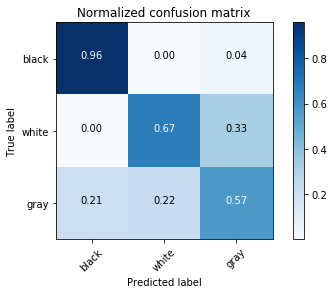

In [164]:
plot_confusion_matrix(c, classes=["black", "white", "gray"], normalize=True,title='Normalized confusion matrix')

In [165]:
picIndex = 15
img = m[picIndex].reshape((120, 120))
img[img==1] = 255
img[img==2] = 128
imgLabel = labels[picIndex].reshape((120,120))
imgLabel[imgLabel==1] = 255
imgLabel[imgLabel==2] = 128

[0 0 0 ... 0 0 0]


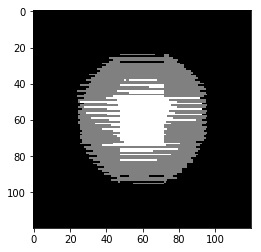

In [166]:
# plt.savefig("mask.png", Image.fromarray(img.astype(np.uint8)))
plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

# plt.savefig("mask.png")

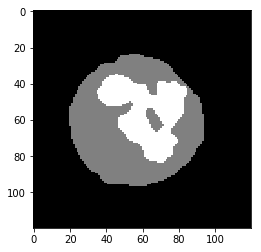

In [167]:
plt.imshow(imgLabel, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

In [117]:
plt.imshow(images[picIndex])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f35f0fba950> (for post_execute):


ValueError: Floating point image RGB values must be in the 0..1 range.

ValueError: Floating point image RGB values must be in the 0..1 range.

In [121]:
print (images[picIndex])

[[[0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  ...
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]]

 [[0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  ...
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]]

 [[0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  ...
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]]

 ...

 [[0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  ...
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]]

 [[0.57305594 0.57305594 0.57305594]
  [0.57305594 0.57305594 0.57305594]


SyntaxError: Missing parentheses in call to 'print'. Did you mean print(images[picIndex])? (<ipython-input-120-48575cfe0d6d>, line 1)